In [ ]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fitter: filename=fitter-1.5.1-py3-none-any.whl size=25596 sha256=c8c87794bc916d5f9d7eaeede94402a1761339663bb03ffa1e45570f42e89cca
  Stored in directory: /root/.cache/pip/wheels/fe/60/a8/447c66eae887b085b3e112358a5fa837104b6cd0d9de41ca71
Successfully built fitter


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
path = "/content/drive/MyDrive/Colab/AMD.csv"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = pd.read_csv(path)
#data.dropna()
data

,Date,Price,Open,High,Low,Vol.,Change %
0,12/01/2022,77.48,78.37,79.19,76.45,59.26M,-0.19%
1,11/30/2022,77.63,73.37,77.70,72.83,86.89M,5.78%
2,11/29/2022,73.39,73.51,74.46,72.79,51.68M,0.27%
3,11/28/2022,73.19,73.61,75.45,72.58,45.00M,-2.60%
4,11/25/2022,75.14,75.46,76.01,74.76,26.00M,-1.65%
...,...,...,...,...,...,...,...
1506,12/07/2016,9.56,9.65,9.79,9.24,54.90M,1.16%
1507,12/06/2016,9.45,8.95,9.54,8.82,92.24M,8.87%
1508,12/05/2016,8.68,8.69,8.71,8.45,31.41M,1.76%
1509,12/02/2016,8.53,8.38,8.74,8.38,42.40M,1.67%


In [ ]:
values = data['Price']
#values = values.str.replace(",","")
values
values = values.astype(float)

In [ ]:
data['Change %'] = data['Change %'].str.replace('%','')

data['Change %'] = data['Change %'].astype(float)

data['Change %'].mean()

0.20810059563203182

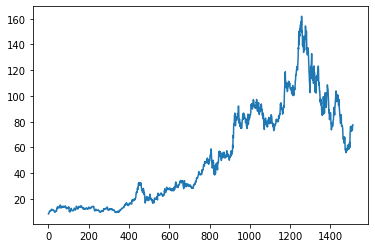

In [ ]:
time = np.linspace(0,len(values),len(values))
time.size
plt.plot(time, values.iloc[::-1])
plt.show()

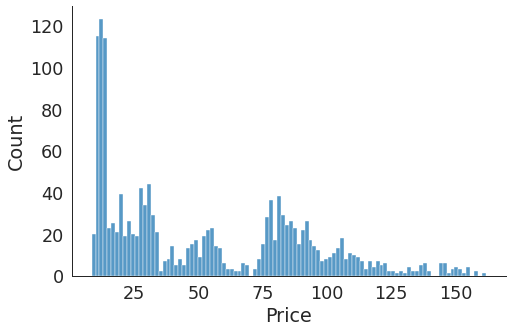

In [ ]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(values, kind="hist", bins = 100, aspect = 1.5)

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.004234,1151.681405,-19296.295742,inf,0.147148,5.086371e-29
gamma,0.004635,1113.535869,-19159.776823,inf,0.135498,1.174655e-24
expon,0.004839,1110.667610,-19101.768123,inf,0.139862,3.007796e-26
exponpow,0.004923,1094.362648,-19068.481627,inf,0.113733,1.756669e-17
powerlaw,0.005354,1049.858790,-18941.847865,inf,0.120202,1.756715e-19


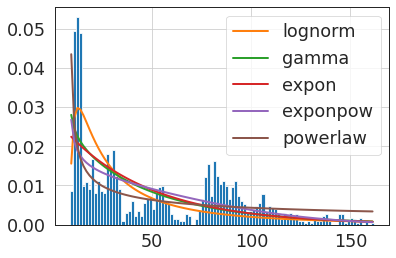

In [ ]:
f = Fitter(values,
           distributions=get_common_distributions()
)
f.fit()
f.summary()

In [ ]:
values.mean(), values.var()

(52.12075446724024, 1476.1520015496076)

In [ ]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 1.2937249581899053,
  'loc': 8.139345574015262,
  'scale': 23.796133268116073}}

In [ ]:
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [ ]:
S = 143
T = 1
r = 0.035
sigma = 0.2
Nsimulations = 10000
Nsteps = 253
K = 145
dt = T/Nsteps

In [ ]:
drift = (r - (sigma**2)/2)*dt
a = sigma*np.sqrt(dt)
x = np.random.normal(0, 1, (Nsimulations, Nsteps))

In [ ]:
Smat = np.zeros((Nsimulations, Nsteps))
Smat[:,0] += S

In [ ]:
for i in range(1,Nsteps):
    Smat[:,i] = Smat[:,i-1] * np.exp(drift + a * x[:,i])

In [ ]:
q = Smat[:,-1]-K
for i in range(len(q)):
    if q[i] < 0:
        q[i] = 0
    else:
        q[i] = q[i]

In [ ]:
p = K - Smat[:,-1]
for i in range(len(p)):
    if p[i] < 0:
        p[i] = 0
    else:
        p[i] = p[i]

In [ ]:
payoff_call = np.mean(q)
payoff_put = np.mean(p)

In [ ]:
call = payoff_call*np.exp(-r*T)
put = payoff_put*np.exp(-r*T)

In [ ]:
from statistics import mean
prediction = mean(Smat[:,-1])
prediction, blackScholes(r, S, prediction, T, sigma, type="c")

(148.23516549971453, 11.327995313897276)

In [ ]:
prediction, blackScholes(r, S, prediction, T, sigma, type="p")

(148.23516549971453, 11.464674000258384)

In [ ]:
time = np.linspace(0,Nsteps,Nsteps)
t = np.full((Nsimulations, Nsteps), time).T
St = Smat.T

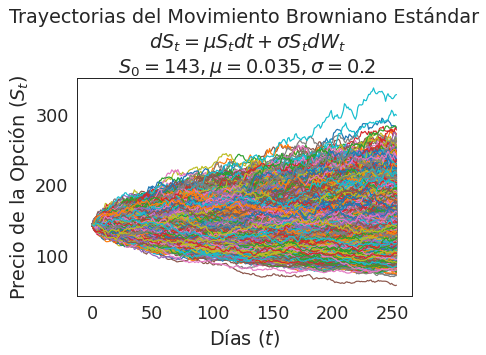

In [ ]:
plt.plot(t, St)
plt.xlabel("Días $(t)$")
plt.ylabel("Precio de la Opción $(S_t)$")
plt.title(
    "Trayectorias del Movimiento Browniano Estándar\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S, r, sigma)
)
plt.show()